In [1]:
from new_main import *
import matplotlib.pyplot as plt

In [2]:
def simulation_run(soglia_spent, alpha, init_publisher_list):
    print(f'Running simulation with budget={soglia_spent} and alpha={alpha}')
    agent_stats = pd.DataFrame()
    comb_linucb = CombinatorialLinUCB(alpha=alpha, d=embedding_size, publisher_list=init_publisher_list)
    for i in range(num_iter):
        if i > 1:
            # After the first two iterations, run Combinatorial LinUCB to change the publisher list
            publisher_list = comb_linucb.round_iteration(init_publisher_list, iteration=i, soglia_spent=soglia_spent)
        else:
            publisher_list = init_publisher_list
        # Compute all agents' similarity with all publishers
        user_contexts, agents_publishers_similarity = initialize_deal(
            publisher_list, publisher_embeddings, rounds_per_iter, agents, adv_embeddings)
        # For each publisher, simulate rounds_per_iter opportunities
        for publisher in publisher_list:
            for j in range(rounds_per_iter):
                current_user_context = user_contexts[publisher.name][j]
                auction.simulate_opportunity(publisher.name, current_user_context, agents_publishers_similarity, j)
        # Update agents bidder and allocator models
        for agent_id, agent in enumerate(auction.agents):
            agent.update(iteration=i)
            # Our agent
            if agent.name.startswith('Nostro'):
                # Get stats for our agent
                agent_stats_pub = agent.iteration_stats_per_publisher()
                # Update Combinatorial LinUCB
                if i < 2:
                    # Initialize Combinatorial LinUCB parameters with the first two iterations
                    publishers_rewards = []
                    for publisher_data in agent_stats_pub:
                        curr_pub = Publisher(
                            name=publisher_data['publisher'],
                            embedding=publisher_embeddings[publisher_data['publisher']],
                            num_auctions=500
                        )
                        publishers_rewards.append(
                            PublisherReward(
                                publisher=curr_pub,
                                reward=publisher_data['num_clicks']
                            )
                        )
                    comb_linucb.initial_round(publishers_rewards, iteration=i)
                else:
                    # Update Combinatorial LinUCB after seeing the rewards
                    for publisher_data in agent_stats_pub:
                        comb_linucb.update(
                            publisher_name=publisher_data['publisher'],
                            publisher_embedding=publisher_embeddings[publisher_data['publisher']],
                            reward=publisher_data['num_clicks'],
                            iteration=i
                        )
                # Save stats for our agent
                agent_df = pd.DataFrame(agent_stats_pub)
                agent_df['Agent'] = agent.name
                agent_df['Iteration'] = i
                if i == 0:
                    agent_stats = agent_df
                else:
                    agent_stats = pd.concat([agent_stats, agent_df])
                # Print stats for our agent
                print(f"Stats after iteration {i}")
                print(f"Number of publishers: {len(agent_df['publisher'].unique())}")
                print(f"Number of clicks at iteration {i}: {agent_df['num_clicks'].sum()}")
                print(f"Spent at iteration {i}: {agent_df['spent'].sum()}")
                # Save stats in Combinatorial LinUCB
                # Group by publisher if there are more than one iteration data
                grouped_data = agent_df.groupby(by=['publisher']) \
                    .sum() \
                    .reset_index() \
                    [['publisher', 'won_auctions', 'lost_auctions', 'num_clicks', 'spent']]
                grouped_data['cpc'] = grouped_data.apply(lambda row: row['spent'] / row['num_clicks'] if row['num_clicks'] > 0 else 0, axis=1)
                comb_linucb.save_stats(grouped_data)

            agent.clear_utility()
            agent.clear_logs()

        auction.clear_revenue()
    # Save LinUCB parameters
    linucb_params = comb_linucb.linucb_params
    # Merge with previously saved parameters
    merged_df = pd.merge(
        agent_stats,
        linucb_params,
        on=['publisher', 'Iteration'],
        how='outer'
    )
    return agent_stats, merged_df

In [3]:
def process_results(budget_results):
    grouped_results = {}
    for budget, results in budget_results.items():
        agent_stats, lin_ucb_params = results
        lin_ucb_params_train = lin_ucb_params[lin_ucb_params['Iteration'] > 1]
        group_iter = lin_ucb_params_train.groupby('Iteration') \
            .agg({'num_clicks': 'sum', 'exp_rew': 'sum', 'spent': 'sum', 'num_clicks_no_noise': 'sum'}) \
            .reset_index()
        group_iter['abs_err'] = np.abs(group_iter['num_clicks'] - group_iter['exp_rew'])
        group_iter['abs_perc_err'] = np.abs(group_iter['num_clicks'] - group_iter['exp_rew']) / group_iter['num_clicks']
        grouped_results[budget] = group_iter
    return grouped_results

In [4]:
save_dir = '../results/budget_70_alpha_tune_pen_0_pub/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [5]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values, num_runs, max_slots, embedding_size, embedding_var, obs_embedding_size, adv_embeddings, publisher_embeddings, knapsack_params = parse_config('../new_config/FP_Truthful_Oracle_alpha_tune.json')

In [6]:
agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
auction, num_iter, rounds_per_iter, output_dir = instantiate_auction(rng, config, agents2items, agents2item_values, agents, max_slots, embedding_size, embedding_var, obs_embedding_size)
publishers = instantiate_publishers(publisher_embeddings)

In [7]:
# Choose 300 publishers at random
rng.shuffle(publishers)
init_publisher_list = publishers[:300]

In [8]:
budget_list = [70]

In [9]:
alpha_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.6]

In [10]:
for budget in budget_list:
    for alpha in alpha_list:
        budget_results = simulation_run(budget, alpha, init_publisher_list)
        agent_stats, lin_ucb_params = budget_results
        # Add num_clicks without noise
        agent_stats['num_clicks_no_noise'] = agent_stats['won_auctions'] * agent_stats['true_ctr']
        lin_ucb_params['num_clicks_no_noise'] = lin_ucb_params['won_auctions'] * lin_ucb_params['true_ctr']
        lin_ucb_params.to_csv(os.path.join(save_dir, f'agent_stats_budget_{budget}_alpha_{alpha}.csv'), index=False)
        # Grouped data
        lin_ucb_params_train = lin_ucb_params[lin_ucb_params['Iteration'] > 1]
        group_iter = lin_ucb_params_train.groupby('Iteration') \
            .agg({'num_clicks': 'sum', 'exp_rew': 'sum', 'spent': 'sum', 'num_clicks_no_noise': 'sum'}) \
            .reset_index()
        group_iter['abs_err'] = np.abs(group_iter['num_clicks'] - group_iter['exp_rew'])
        group_iter['abs_perc_err'] = np.abs(group_iter['num_clicks'] - group_iter['exp_rew']) / group_iter['num_clicks']
        group_iter.to_csv(os.path.join(save_dir, f'grouped_results_per_iter_budget_{budget}_alpha_{alpha}.csv'), index=False)

Running simulation with budget=70 and alpha=0


/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7664.0
Spent at iteration 0: 394.3128967473705
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8255.0
Spent at iteration 1: 422.71846234668016
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.6400412470701
Stats after iteration 2
Number of publishers: 42
Number of clicks at iteration 2: 1642.0
Spent at iteration 2: 83.02142048640226
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.57192526375701
Stats after iteration 3
Number of publishers: 32
Number of clicks at iteration 3: 1484.0
Spent at iteration 3: 75.53942087182352
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.09873296788625
Stats after iteration 4
Number of publishers: 29
Number of clicks at iteration 4: 1392.0
Spent at iteration 4: 70.84062050557766
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.0062803897733
Stats after iteration 5
Number of publishers: 28
Number of clicks at i

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8131.0
Spent at iteration 0: 414.0862329097656
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8404.0
Spent at iteration 1: 422.3319022625799
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.47445877941799
Stats after iteration 2
Number of publishers: 46
Number of clicks at iteration 2: 1497.0
Spent at iteration 2: 77.77176982355327
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.39163650057216
Stats after iteration 3
Number of publishers: 37
Number of clicks at iteration 3: 1347.0
Spent at iteration 3: 68.96526772923374
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.97596564524338
Stats after iteration 4
Number of publishers: 37
Number of clicks at iteration 4: 1765.0
Spent at iteration 4: 88.97864660993372
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99981446906274
Stats after iteration 5
Number of publishers: 30
Number of clicks at 

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8344.0
Spent at iteration 0: 420.41967536886415
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8128.0
Spent at iteration 1: 414.87670093236557
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.41958734440001
Stats after iteration 2
Number of publishers: 39
Number of clicks at iteration 2: 2089.0
Spent at iteration 2: 106.21173466320568
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.38710408394216
Stats after iteration 3
Number of publishers: 35
Number of clicks at iteration 3: 1459.0
Spent at iteration 3: 72.95500602458144
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.97540899489458
Stats after iteration 4
Number of publishers: 30
Number of clicks at iteration 4: 1326
Spent at iteration 4: 70.41839723568509
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99986420274269
Stats after iteration 5
Number of publishers: 32
Number of clicks at

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8489.0
Spent at iteration 0: 433.8472261089744
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8256.0
Spent at iteration 1: 416.62956464895586
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.9849777761506
Stats after iteration 2
Number of publishers: 43
Number of clicks at iteration 2: 1724.0
Spent at iteration 2: 89.58380999599702
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.57443245860135
Stats after iteration 3
Number of publishers: 35
Number of clicks at iteration 3: 1498
Spent at iteration 3: 78.18323924324804
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.98321545881835
Stats after iteration 4
Number of publishers: 34
Number of clicks at iteration 4: 1351.0
Spent at iteration 4: 69.55143167801397
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.46064416366563
Stats after iteration 5
Number of publishers: 37
Number of clicks at it

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7995.0
Spent at iteration 0: 408.5091502984376
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 7922.0
Spent at iteration 1: 403.0189697639139
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99662679895349
Stats after iteration 2
Number of publishers: 54
Number of clicks at iteration 2: 1991.0
Spent at iteration 2: 99.95052597647792
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.08336031969253
Stats after iteration 3
Number of publishers: 42
Number of clicks at iteration 3: 1446.0
Spent at iteration 3: 75.9977332464938
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.61280287102109
Stats after iteration 4
Number of publishers: 41
Number of clicks at iteration 4: 1383.0
Spent at iteration 4: 71.8638661728616
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99083584550495
Stats after iteration 5
Number of publishers: 36
Number of clicks at it

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8449.0
Spent at iteration 0: 430.5316487936045
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8551.0
Spent at iteration 1: 432.8685962411024
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.49135434763375
Stats after iteration 2
Number of publishers: 48
Number of clicks at iteration 2: 1579.0
Spent at iteration 2: 79.2986905769527
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99853144281717
Stats after iteration 3
Number of publishers: 37
Number of clicks at iteration 3: 1519.0
Spent at iteration 3: 76.10655476757934
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.72499662342985
Stats after iteration 4
Number of publishers: 39
Number of clicks at iteration 4: 1344.0
Spent at iteration 4: 70.44843064437217
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.67394455687457
Stats after iteration 5
Number of publishers: 37
Number of clicks at i

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8295.0
Spent at iteration 0: 421.85867257643037
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8318.0
Spent at iteration 1: 423.53195403211873
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.9943701805942
Stats after iteration 2
Number of publishers: 53
Number of clicks at iteration 2: 1692.0
Spent at iteration 2: 85.64525490652562
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99889961298928
Stats after iteration 3
Number of publishers: 40
Number of clicks at iteration 3: 1387
Spent at iteration 3: 72.65895973162908
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.99747365206383
Stats after iteration 4
Number of publishers: 42
Number of clicks at iteration 4: 1585.0
Spent at iteration 4: 81.01496018443085
Knapsack Solver: Soluzione ottimale trovata!
Spent = 69.82230710667446
Stats after iteration 5
Number of publishers: 39
Number of clicks at i

In [13]:
def plot_results(grouped_results):
    # Plot absolute percentage error
    for budget, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['abs_perc_err'].to_numpy(), label=f'budget={budget}')
    plt.xlabel('Iteration')
    plt.ylabel('Absolute percentage error')
    plt.legend()
    # Plot expected reward
    plt.figure()
    for budget, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['exp_rew'].to_numpy(), label=f'budget={budget}')
    plt.xlabel('Iteration')
    plt.ylabel('Expected reward')
    # Plot number of clicks
    plt.figure()
    for budget, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['num_clicks'].to_numpy(), label=f'budget={budget}')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    # Plot number of clicks without noise
    plt.figure()
    for budget, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['num_clicks_no_noise'].to_numpy(), label=f'budget={budget}')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks without noise')
    plt.show()

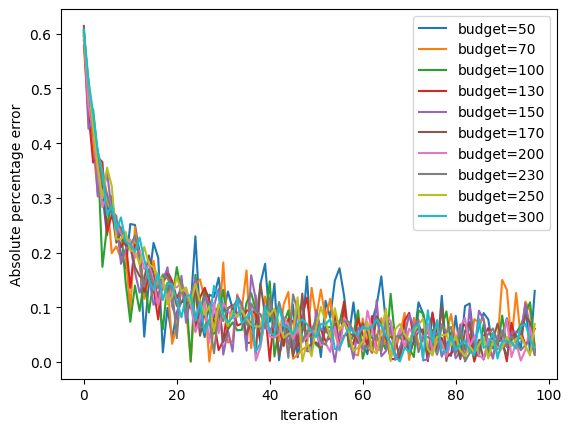

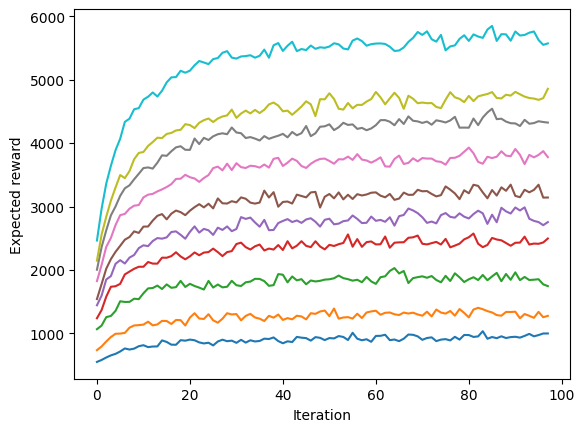

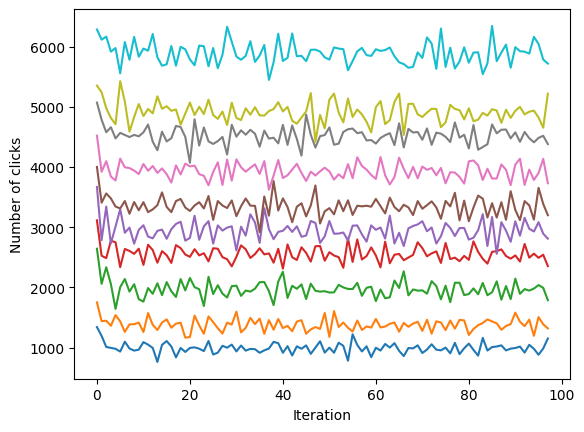

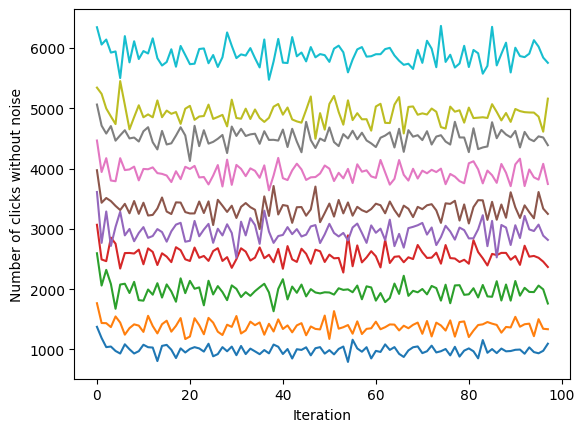

In [14]:
plot_results(grouped_results)

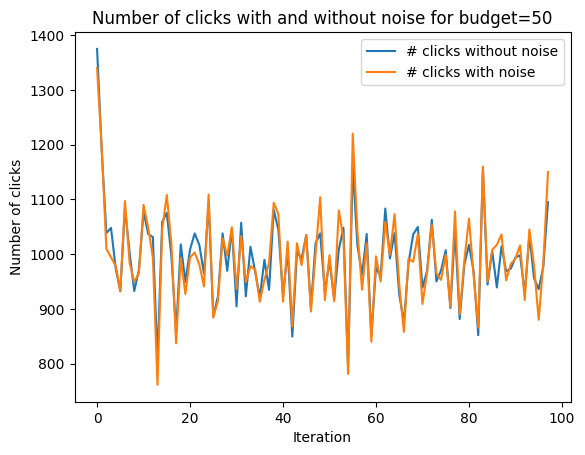

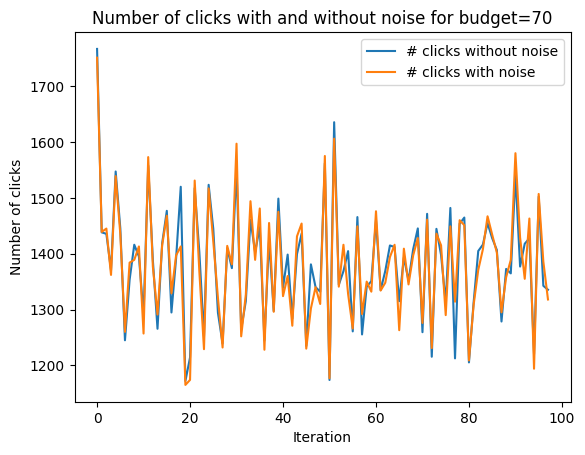

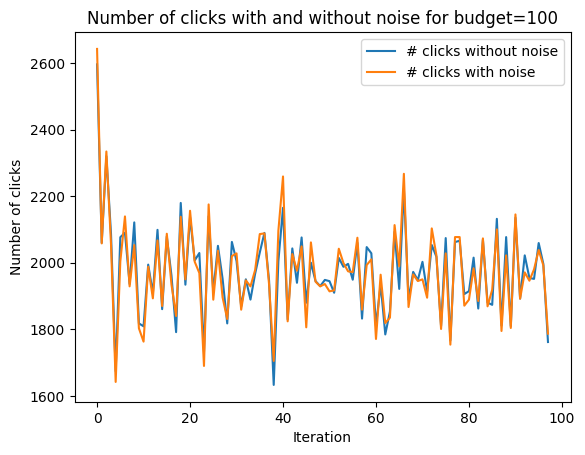

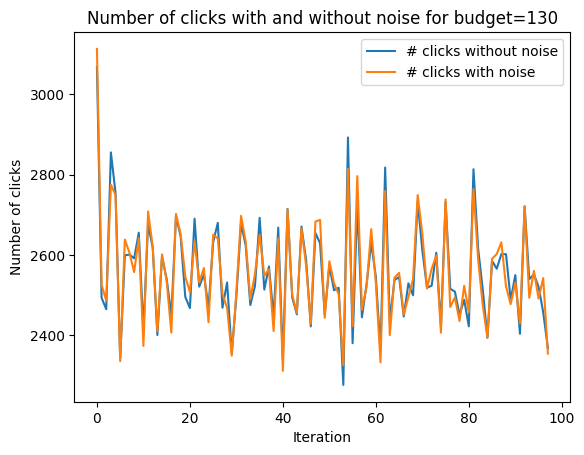

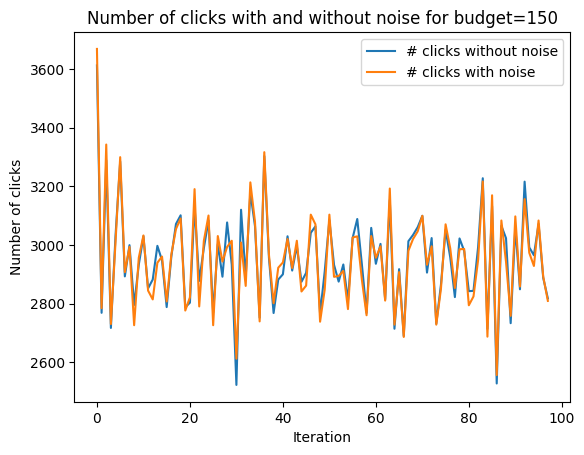

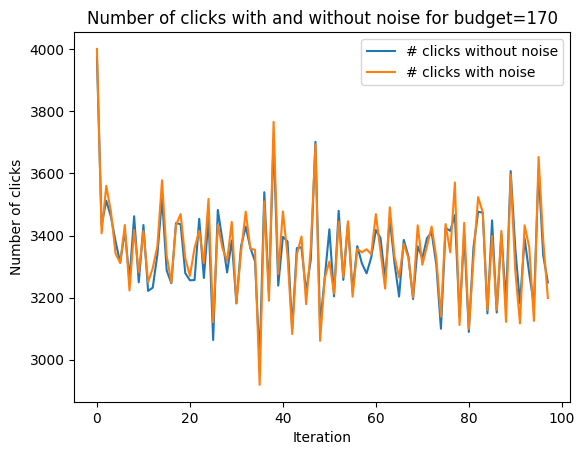

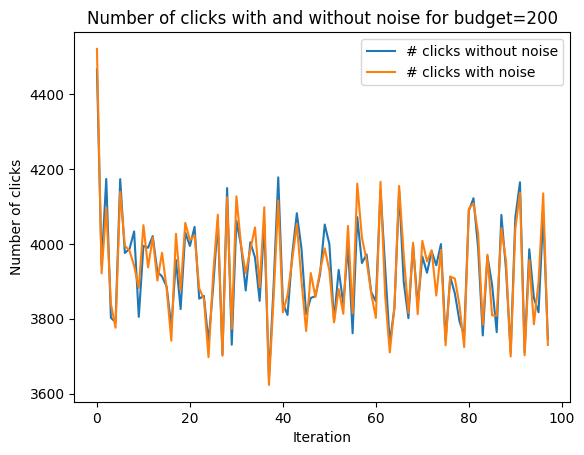

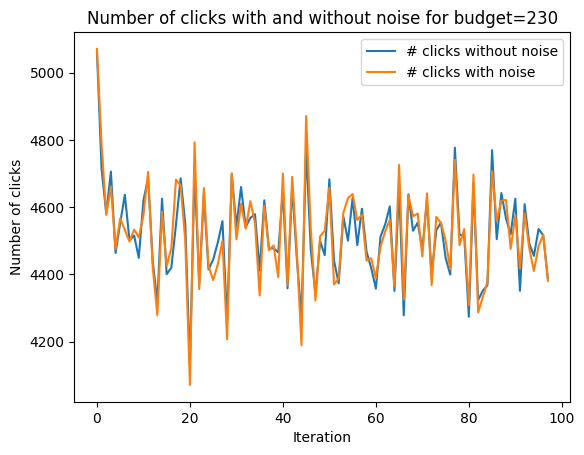

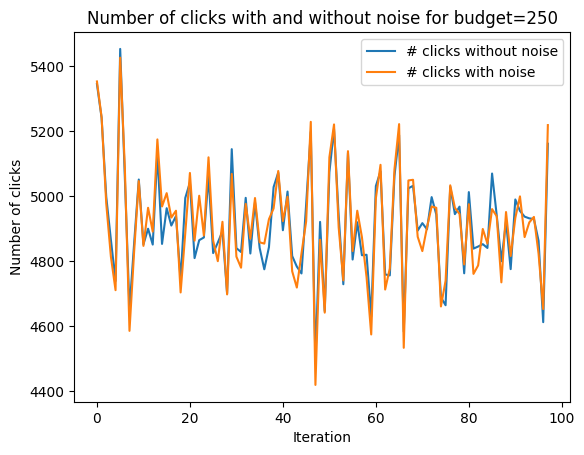

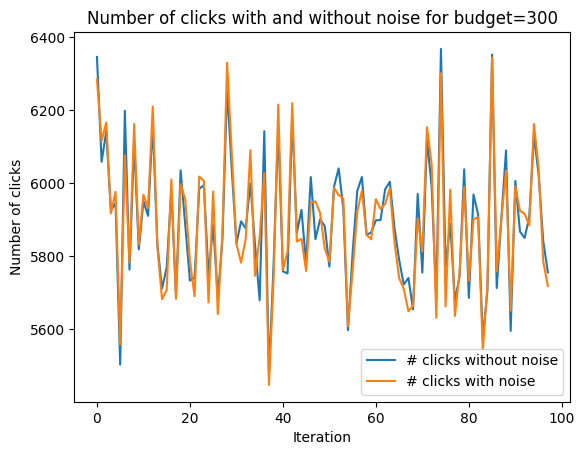

In [15]:
# Plot number of clicks without noise for each budget with a separate plot
for budget, results in grouped_results.items():
    plt.title(f'Number of clicks with and without noise for budget={budget}')
    plt.plot(results.index.to_numpy(), results['num_clicks_no_noise'].to_numpy(), label=f'# clicks without noise')
    plt.plot(results.index.to_numpy(), results['num_clicks'].to_numpy(), label=f'# clicks with noise')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    plt.legend()
    plt.show()

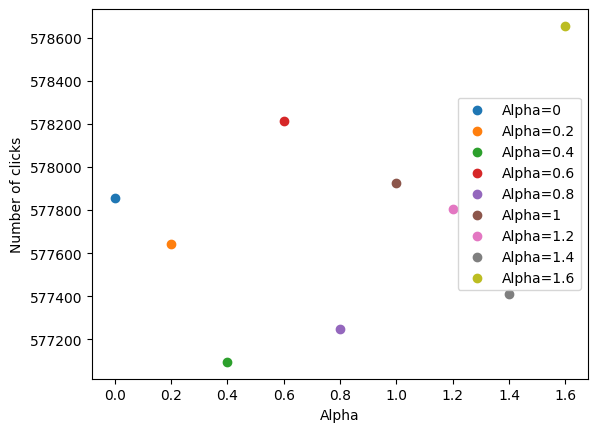

In [55]:
# Plot number of clicks and budget
for budget, results in grouped_results.items():
    plt.scatter(budget, results['num_clicks'].sum(), label=f'budget={budget}')
plt.xlabel('budget')
plt.ylabel('Number of clicks')
plt.legend()
plt.show()

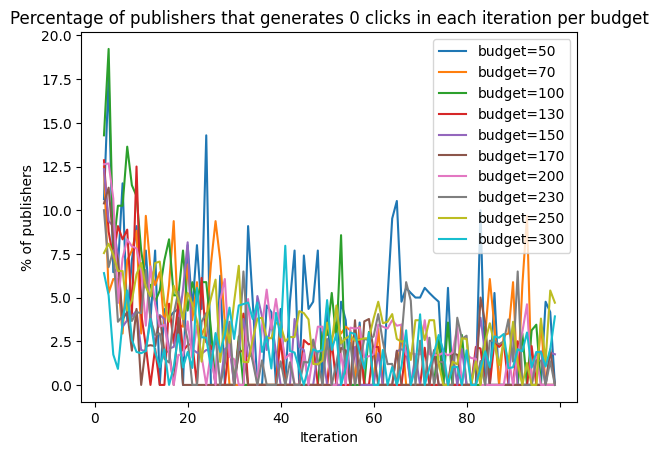

In [35]:
for budget, results in budget_results.items():
    agent_stats, lin_ucb_params = results
    all_iterations = lin_ucb_params['Iteration'].unique()
    zero_clicks = lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['num_clicks'] == 0)] \
        .groupby('Iteration').size().reset_index(name='count') \
        .set_index('Iteration').reindex(all_iterations, fill_value=0)
    total = lin_ucb_params[(lin_ucb_params['Iteration'] > 1)] \
        .groupby('Iteration').size().reset_index(name='count') \
        .set_index('Iteration').reindex(all_iterations, fill_value=0)
    perc_zero_clicks = (zero_clicks['count'] / total['count']) * 100
    perc_zero_clicks = perc_zero_clicks.sort_index()
    perc_zero_clicks.plot(label=f'budget={budget}')
    plt.title("Percentage of publishers that generates 0 clicks in each iteration per budget")
    plt.xlabel('Iteration')
    plt.ylabel('% of publishers')
    plt.legend()